In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import pickle
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:

# Load the dataset
df = pd.read_csv('project_dataset.csv')

In [4]:
# Thresholds for isolation labels
physical_threshold = 5
social_threshold = 10
digital_threshold = 0.3

# Defining the columns
df['physically_isolated'] = (df['outdoor_activities'] < physical_threshold) & (df['family_time'] < physical_threshold)
df['socially_isolated'] = (df['community_events'] < social_threshold) & (df['family_time'] < social_threshold)
df['digitally_isolated'] = (df['total_screen_time'] > 0) & (
    (df['social_networking'] + df['gaming'] + df['entertainment']) / df['total_screen_time'] < digital_threshold)

# Convert boolean to 1 and 0
df['physically_isolated'] = df['physically_isolated'].astype(int)
df['socially_isolated'] = df['socially_isolated'].astype(int)
df['digitally_isolated'] = df['digitally_isolated'].astype(int)

# Define features and target
features = ['total_screen_time', 'social_networking', 'reading_and_research', 'other', 
            'productivity', 'health_and_fitness', 'entertainment', 'creativity', 'yoga', 
            'movies', 'gaming', 'community_events', 'family_time', 'outdoor_activities', 'volunteering']

X = df[features]
y = df[['physically_isolated', 'socially_isolated', 'digitally_isolated']]

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to the data
smote = SMOTE(random_state=42)
X_train_physical, y_train_physical = smote.fit_resample(X_train, y_train['physically_isolated'])
X_train_social, y_train_social = smote.fit_resample(X_train, y_train['socially_isolated'])
X_train_digital, y_train_digital = smote.fit_resample(X_train, y_train['digitally_isolated'])


In [6]:
X_train_physical = np.expand_dims(X_train_physical, axis=-1)
X_train_social = np.expand_dims(X_train_social, axis=-1)
X_train_digital = np.expand_dims(X_train_digital, axis=-1)

X_test = np.expand_dims(X_test, axis=-1)

In [7]:


# Build the CNN model
def build_cnn_model():
    model = models.Sequential()
    model.add(layers.Conv1D(64, 2, activation='relu', input_shape=(X_train_physical.shape[1], 1)))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(128, 2, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [8]:
# Train the CNN models
physical_model = build_cnn_model()
social_model = build_cnn_model()
digital_model = build_cnn_model()

physical_model.fit(X_train_physical, y_train_physical, epochs=10, batch_size=32, validation_split=0.2)
social_model.fit(X_train_social, y_train_social, epochs=10, batch_size=32, validation_split=0.2)
digital_model.fit(X_train_digital, y_train_digital, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7627 - loss: 0.7048 - val_accuracy: 1.0000 - val_loss: 0.0315
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9769 - loss: 0.0762 - val_accuracy: 1.0000 - val_loss: 0.0499
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9895 - loss: 0.0400 - val_accuracy: 1.0000 - val_loss: 0.0990
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9958 - loss: 0.0335 - val_accuracy: 1.0000 - val_loss: 0.0410
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9936 - loss: 0.0348 - val_accuracy: 1.0000 - val_loss: 0.0463
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9966 - loss: 0.0225 - val_accuracy: 1.0000 - val_loss: 0.0234
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9941 - loss: 0.0208 - val_accuracy: 1.0000 - val_loss: 0.0121
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9947 - loss: 0.0240 - val_accuracy: 0.9939 - val_l

In [14]:
# Save models in the native Keras format
physical_model.save('physical_isolation_cnn_model.keras')
social_model.save('social_isolation_cnn_model.keras')
digital_model.save('digital_isolation_cnn_model.keras')

print("CNN models saved successfully in the Keras format.")


CNN models saved successfully in the Keras format.


In [15]:
# Evaluate models on test set
y_pred_physical = physical_model.predict(X_test)
y_pred_social = social_model.predict(X_test)
y_pred_digital = digital_model.predict(X_test)

# Convert predictions to binary (thresholding at 0.5)
y_pred_physical = (y_pred_physical > 0.5).astype(int)
y_pred_social = (y_pred_social > 0.5).astype(int)
y_pred_digital = (y_pred_digital > 0.5).astype(int)

# Evaluate each model
print("\nPhysical Isolation Model Evaluation:")
print("Accuracy:", accuracy_score(y_test['physically_isolated'], y_pred_physical))
print("Precision:", precision_score(y_test['physically_isolated'], y_pred_physical))
print("Recall:", recall_score(y_test['physically_isolated'], y_pred_physical))
print("F1 Score:", f1_score(y_test['physically_isolated'], y_pred_physical))

print("\nSocial Isolation Model Evaluation:")
print("Accuracy:", accuracy_score(y_test['socially_isolated'], y_pred_social))
print("Precision:", precision_score(y_test['socially_isolated'], y_pred_social))
print("Recall:", recall_score(y_test['socially_isolated'], y_pred_social))
print("F1 Score:", f1_score(y_test['socially_isolated'], y_pred_social))

print("\nDigital Isolation Model Evaluation:")
print("Accuracy:", accuracy_score(y_test['digitally_isolated'], y_pred_digital))
print("Precision:", precision_score(y_test['digitally_isolated'], y_pred_digital))
print("Recall:", recall_score(y_test['digitally_isolated'], y_pred_digital))
print("F1 Score:", f1_score(y_test['digitally_isolated'], y_pred_digital))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Physical Isolation Model Evaluation:
Accuracy: 0.9888888888888889
Precision: 0.6
Recall: 1.0
F1 Score: 0.75

Social Isolation Model Evaluation:
Accuracy: 0.9333333333333333
Precision: 0.6923076923076923
Recall: 1.0
F1 Score: 0.8181818181818182

Digital Isolation Model Evaluation:
Accuracy: 0.9777777777777777
Precision: 1.0
Recall: 0.9183673469387755
F1 Score: 0.9574468085106383


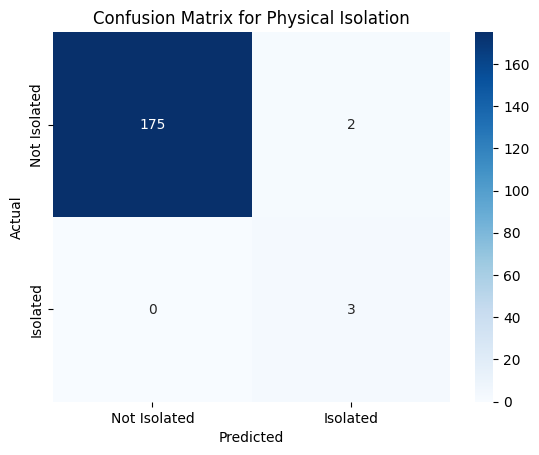

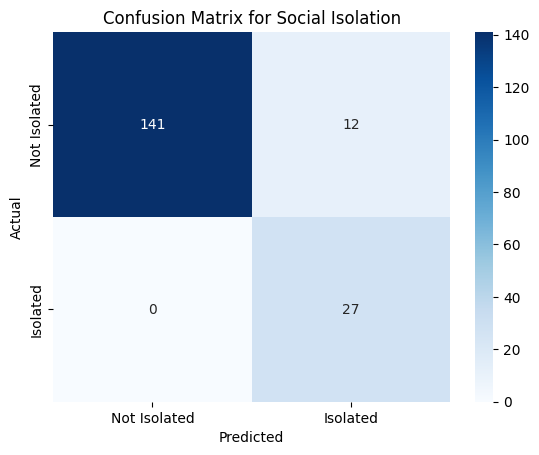

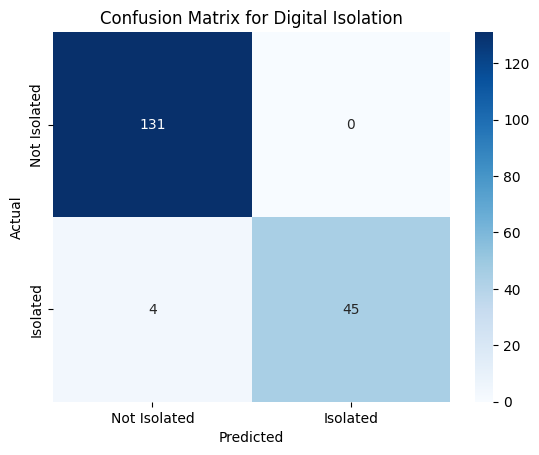

In [17]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define function to plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Isolated", "Isolated"], yticklabels=["Not Isolated", "Isolated"])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrices for each model
plot_confusion_matrix(y_test['physically_isolated'], y_pred_physical, 'Physical Isolation')
plot_confusion_matrix(y_test['socially_isolated'], y_pred_social, 'Social Isolation')
plot_confusion_matrix(y_test['digitally_isolated'], y_pred_digital, 'Digital Isolation')


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


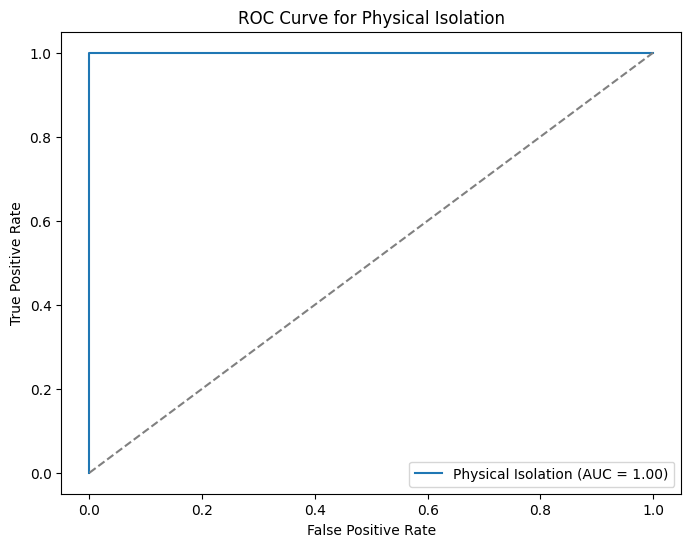

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


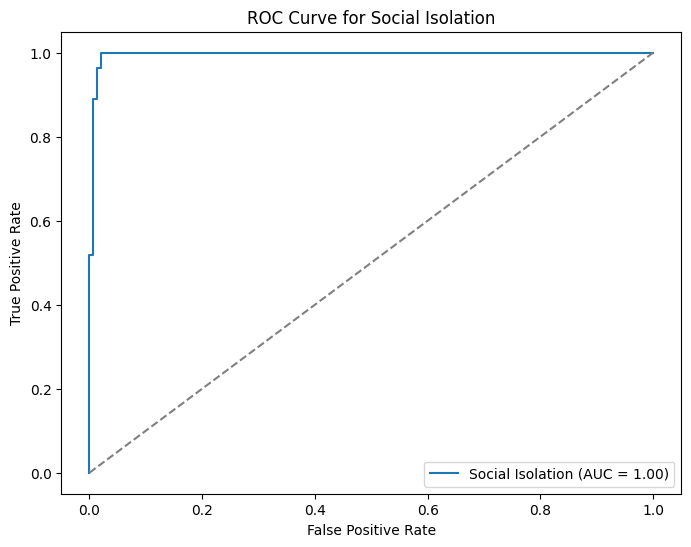

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


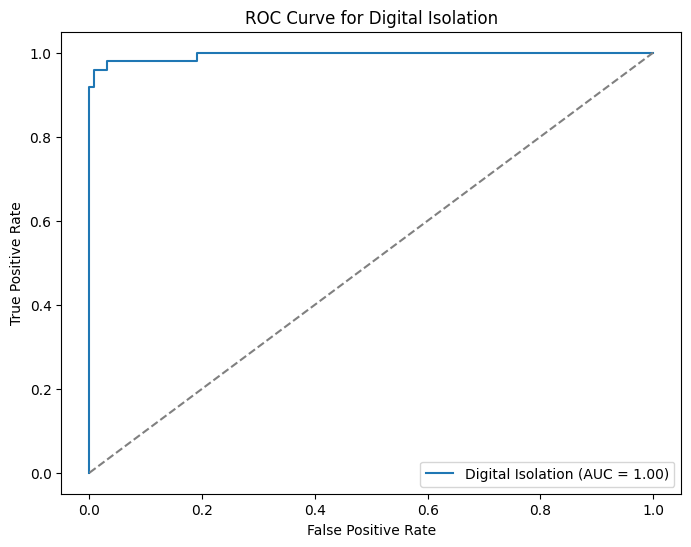

In [18]:
# Feature importance (since CNNs don't give feature importance directly, we'll skip this part)
# Plot ROC curve
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title(f'ROC Curve for {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(y_test['physically_isolated'], physical_model.predict(X_test), 'Physical Isolation')
plot_roc_curve(y_test['socially_isolated'], social_model.predict(X_test), 'Social Isolation')
plot_roc_curve(y_test['digitally_isolated'], digital_model.predict(X_test), 'Digital Isolation')


In [19]:
import pandas as pd
from tensorflow.keras.models import load_model  # For loading CNN models

# Load the CNN models
physical_model = load_model('physical_isolation_cnn_model.keras')
social_model = load_model('social_isolation_cnn_model.keras')
digital_model = load_model('digital_isolation_cnn_model.keras')

# Define a function to make predictions using all 15 features with proper column names
def predict_isolation(all_features):
    # Define the column names as they were in the training data
    features = [
        'total_screen_time', 'social_networking', 'reading_and_research', 'other', 
        'productivity', 'health_and_fitness', 'entertainment', 'creativity', 'yoga', 
        'movies', 'gaming', 'community_events', 'family_time', 'outdoor_activities', 'volunteering'
    ]
    
    # Convert the input data to a DataFrame
    input_data = pd.DataFrame([all_features], columns=features)
    
    # If necessary, preprocess `input_data` the same way you did during training
    # (e.g., scaling, reshaping). Here, let's assume it needs reshaping to match CNN input.

    # Reshape the input data to match the input shape expected by CNN models
    # For example, if CNN expects shape (batch_size, 15, 1) for 1D convolution, use:
    input_data_reshaped = input_data.values.reshape(1, 15, 1)

    # Predict each type of isolation using the respective model
    physical_pred = (physical_model.predict(input_data_reshaped) > 0.5).astype("int32")[0][0]
    social_pred = (social_model.predict(input_data_reshaped) > 0.5).astype("int32")[0][0]
    digital_pred = (digital_model.predict(input_data_reshaped) > 0.5).astype("int32")[0][0]
    
    # Print the results
    print(f"Physical Isolation: {'Isolated' if physical_pred else 'Not Isolated'}, "
          f"Social Isolation: {'Isolated' if social_pred else 'Not Isolated'}, "
          f"Digital Isolation: {'Isolated' if digital_pred else 'Not Isolated'}")

# Example usage of the function with all 15 features (replace with your input data)
input_data = [15, 5, 3, 2, 1, 4, 2, 3, 1, 4, 5, 6, 4, 2, 0]  # Example data
predict_isolation(input_data)


C:\Users\karan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Physical Isolation: Not Isolated, Social Isolation: Not Isolated, Digital Isolation: Not Isolated


In [3]:
from tensorflow.keras.models import load_model

# Load the saved models
physical_model = load_model('physical_isolation_cnn_model.keras')
social_model = load_model('social_isolation_cnn_model.keras')
digital_model = load_model('digital_isolation_cnn_model.keras')


C:\Users\karan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


C:\Users\karan\AppData\Local\Temp\ipykernel_7848\1091853729.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='physically_isolated', palette="Blues")


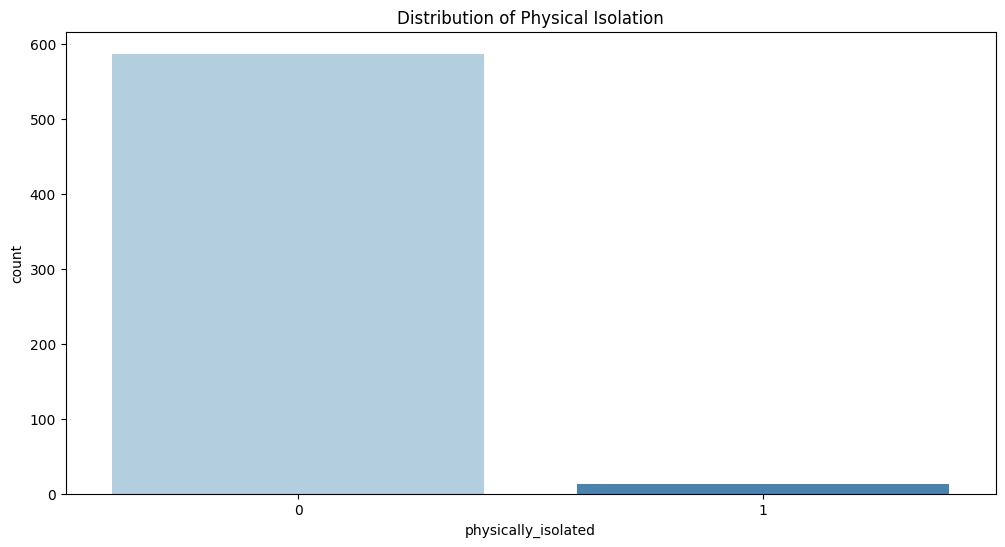

C:\Users\karan\AppData\Local\Temp\ipykernel_7848\1091853729.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='socially_isolated', palette="Greens")


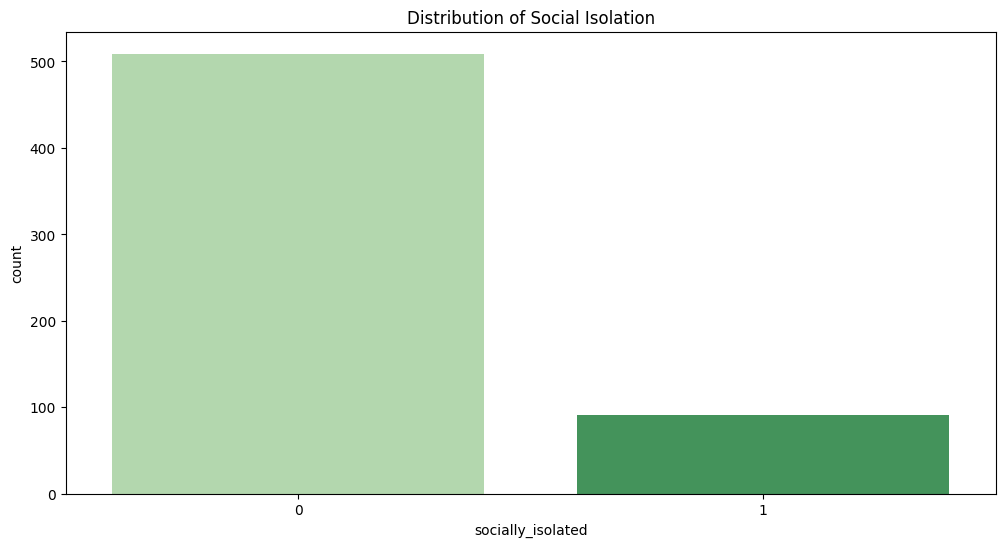

C:\Users\karan\AppData\Local\Temp\ipykernel_7848\1091853729.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='digitally_isolated', palette="Oranges")


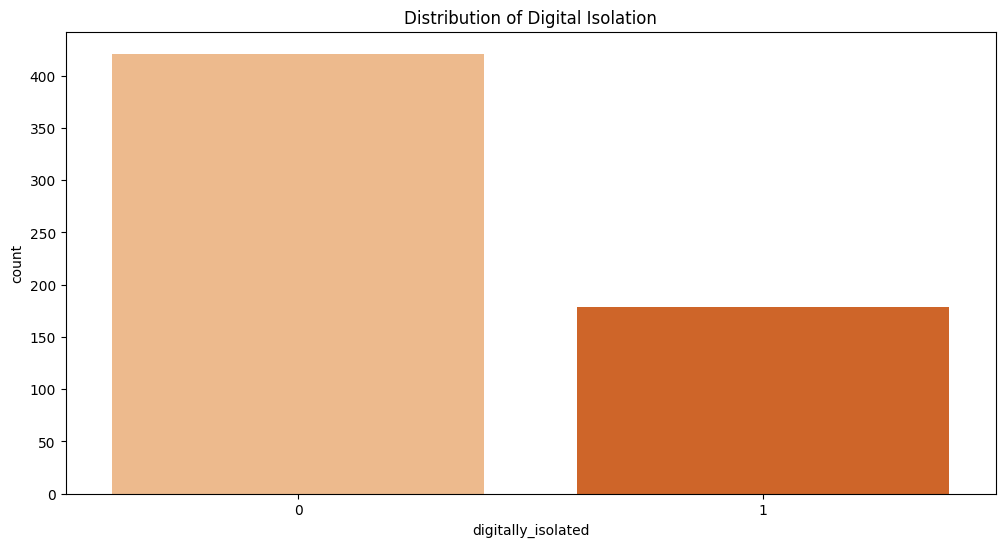

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot distribution of isolation labels
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='physically_isolated', palette="Blues")
plt.title('Distribution of Physical Isolation')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='socially_isolated', palette="Greens")
plt.title('Distribution of Social Isolation')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='digitally_isolated', palette="Oranges")
plt.title('Distribution of Digital Isolation')
plt.show()


In [11]:
# Assuming X_test has shape (n_samples, height, width, channels)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)  # Flatten the image to 2D
